In [ ]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
input_img = Input(shape=(256, 256, 3))

l1 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(input_img)
l2 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l1)
l3 = MaxPooling2D(padding='same')(l2)
l3 = Dropout(0.3)(l3)
l4 = Conv2D(128, (3, 3),  padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l3)
l5 = Conv2D(128, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l4)
l6 = MaxPooling2D(padding='same')(l5)
l7 = Conv2D(256, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l6)
encoder = Model(input_img, l7)

In [ ]:
encoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 128)    

In [ ]:
l8 = UpSampling2D()(l7)

l9 = Conv2D(128, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l8)
l10 = Conv2D(128, (3, 3), padding='same', activation='relu',
             activity_regularizer=regularizers.l1(10e-10))(l9)

l11 = add([l5, l10])
l12 = UpSampling2D()(l11)
l13 = Conv2D(64, (3, 3), padding='same', activation='relu',
             activity_regularizer=regularizers.l1(10e-10))(l12)
l14 = Conv2D(64, (3, 3), padding='same', activation='relu',
             activity_regularizer=regularizers.l1(10e-10))(l13)

l15 = add([l14, l2])

# chan = 3, for RGB
decoded = Conv2D(3, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l15)

# Create our network
autoencoder = Model(input_img, decoded)
# You'll understand later what this is
autoencoder_hfenn = Model(input_img, decoded)

In [ ]:
autoencoder.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
_______________________________________________________________________________________

In [ ]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
from os import listdir
from matplotlib import image
from skimage.transform import resize, rescale
import cv2
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import numpy as np
from skimage import img_as_ubyte

In [ ]:
filename="0001.png"
img_data = image.imread('/content/drive/My Drive/DIV2K_train_HR/' + filename)
image_resized = resize(img_data, (256, 256))

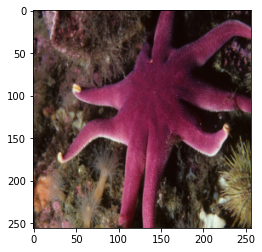

In [ ]:
plt.imshow(image_resized)

In [ ]:
import random
def shuffle(samples):
    shuffled=random.sample(samples, len(samples))  
    return shuffled

In [ ]:
samples=[]
for filename in listdir('/content/drive/My Drive/DIV2K_train_HR'):
  samples.append(filename)
  print(filename +" Name uploaded to Samples")

0339.png Name uploaded to Samples
0338.png Name uploaded to Samples
0344.png Name uploaded to Samples
0337.png Name uploaded to Samples
0345.png Name uploaded to Samples
0347.png Name uploaded to Samples
0351.png Name uploaded to Samples
0348.png Name uploaded to Samples
0349.png Name uploaded to Samples
0346.png Name uploaded to Samples
0352.png Name uploaded to Samples
0350.png Name uploaded to Samples
0353.png Name uploaded to Samples
0360.png Name uploaded to Samples
0357.png Name uploaded to Samples
0358.png Name uploaded to Samples
0356.png Name uploaded to Samples
0359.png Name uploaded to Samples
0355.png Name uploaded to Samples
0354.png Name uploaded to Samples
0369.png Name uploaded to Samples
0365.png Name uploaded to Samples
0367.png Name uploaded to Samples
0371.png Name uploaded to Samples
0361.png Name uploaded to Samples
0364.png Name uploaded to Samples
0366.png Name uploaded to Samples
0372.png Name uploaded to Samples
0363.png Name uploaded to Samples
0370.png Name 

In [ ]:
def create_mask(img):
  mask = np.full((256,256,3), 0, np.uint8)
  for _ in range(np.random.randint(1, 10)):
    x1, x2 = np.random.randint(1, 256), np.random.randint(1, 256)
    y1, y2 = np.random.randint(1, 256), np.random.randint(1, 256)
    thickness = 7
    cv2.line(mask,(x1,y1),(x2,y2),(255,255,255),thickness)
  masked_image = img.copy()
  image_resized = resize(masked_image, (256, 256))
  return img_as_ubyte(image_resized), mask

In [ ]:
def generator(samples,batch_size=10):
    num_samples = len(samples)
    while True:
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            X_train = []
            y_train = []
            for sample_file in batch_samples:
                img_data = image.imread('/content/drive/My Drive/DIV2K_train_HR/'+sample_file)
                image_resized = resize(img_data, (256, 256))
                img,mask=create_mask(image_resized)
                masked=cv2.bitwise_or(img,mask)
                X_train.append(masked)
                y_train.append(img)
            X_train = np.array(X_train)
            y_train = np.array(y_train)
            yield X_train, y_train

In [ ]:
train_datagen = generator(samples)

In [ ]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("/content/drive/My Drive/IoTDemo/imbestmodel.h5",save_best_only=True, mode='min',monitor='loss', verbose=1)
callbacks_list = [checkpoint]

In [ ]:
model=autoencoder.fit(train_datagen,epochs=80,steps_per_epoch=20,verbose=1,callbacks=callbacks_list)

Epoch 1/80
20/20 [==============================] - ETA: 0s - loss: 15337.2900 
Epoch 00001: loss improved from inf to 15337.29004, saving model to /content/drive/My Drive/IoTDemo/imbestmodel.h5
20/20 [==============================] - 249s 12s/step - loss: 15337.2900
Epoch 2/80
20/20 [==============================] - ETA: 0s - loss: 2465.5042 
Epoch 00002: loss improved from 15337.29004 to 2465.50415, saving model to /content/drive/My Drive/IoTDemo/imbestmodel.h5
20/20 [==============================] - 281s 14s/step - loss: 2465.5042
Epoch 3/80
20/20 [==============================] - ETA: 0s - loss: 1568.7003 
Epoch 00003: loss improved from 2465.50415 to 1568.70032, saving model to /content/drive/My Drive/IoTDemo/imbestmodel.h5
20/20 [==============================] - 279s 14s/step - loss: 1568.7003
Epoch 4/80
20/20 [==============================] - ETA: 0s - loss: 1238.9937 
Epoch 00004: loss improved from 1568.70032 to 1238.99365, saving model to /content/drive/My Drive/IoTDemo

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from keras.models import load_model
Imip=load_model('/content/drive/My Drive/IoTDemo/imbestmodel.h5')

In [ ]:
Imip.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
_______________________________________________________________________________________

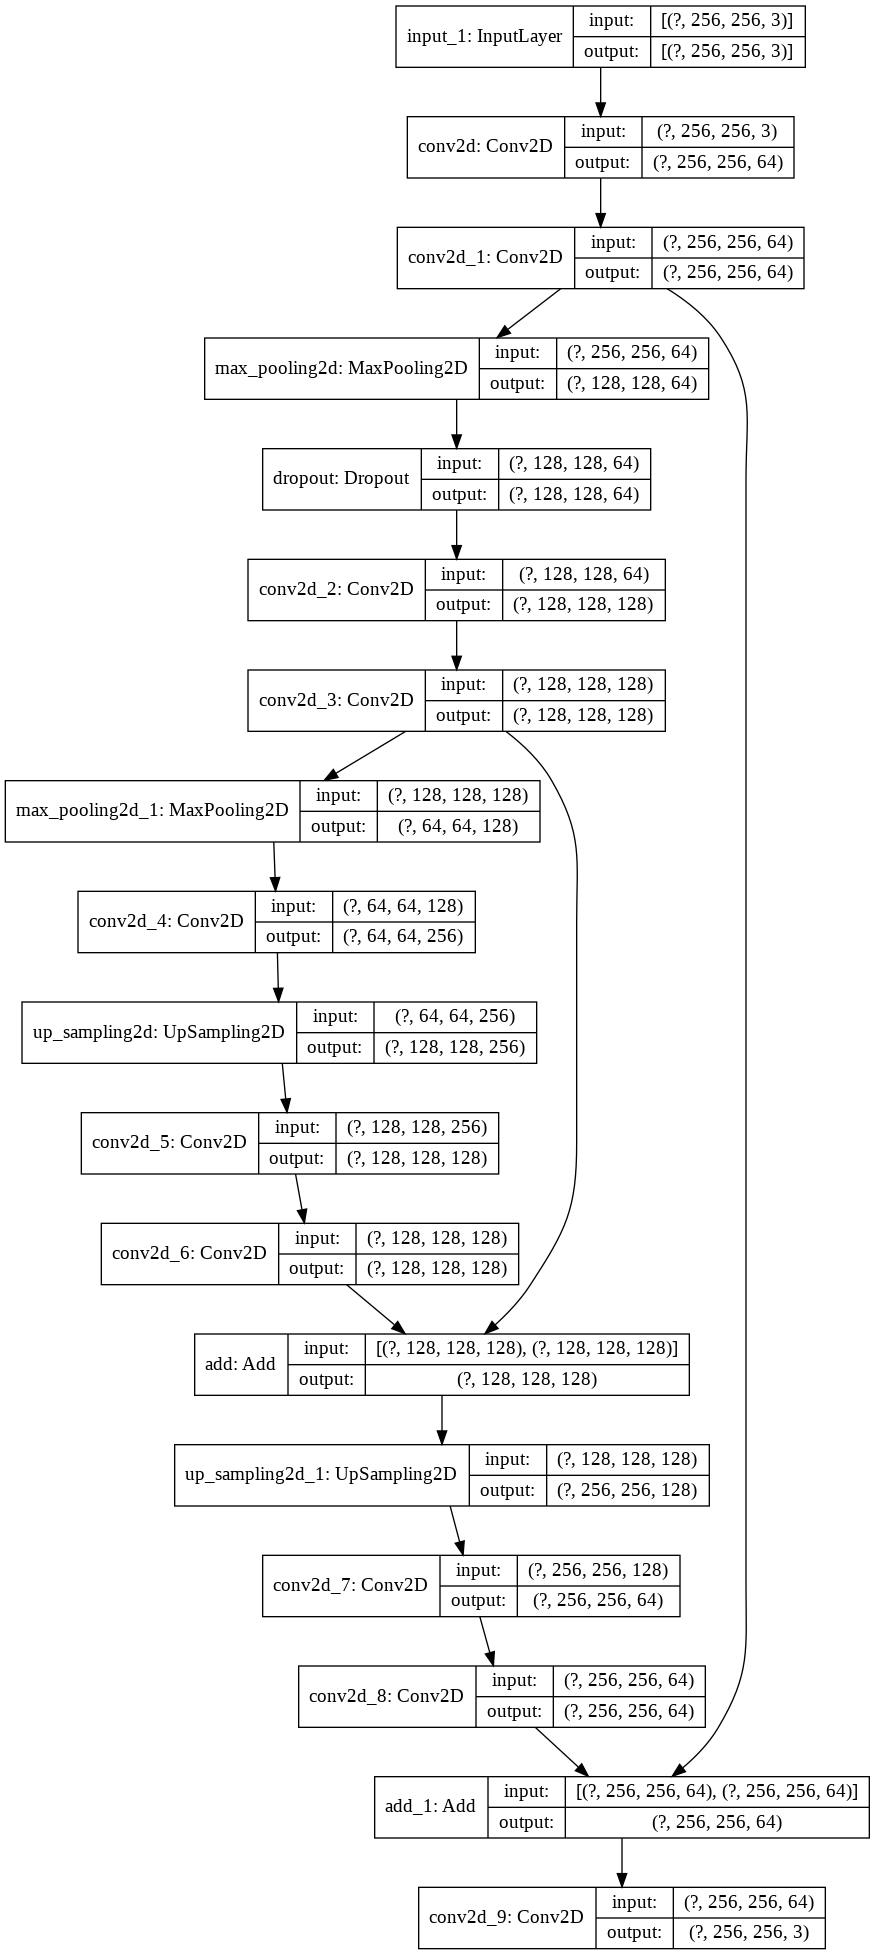

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(Imip, to_file='/content/drive/My Drive/IoTDemo/superres_model_plot.png', show_shapes=True, show_layer_names=True)